# [PBMC example](https://github.com/immunogenomics/symphony/blob/main/vignettes/pbmcs_tutorial.ipynb) from the Symphony repo

In [1]:
import os
import sys

JUPYTER_DIR = os.path.dirname(os.path.abspath("__file__"))
SYMPHONY_DIR = os.path.dirname(JUPYTER_DIR)
sys.path.append(SYMPHONY_DIR)
sys.path

['/home/ku/projs/symphony/benchmarking',
 '/home/ku/mambaforge/envs/symphony/lib/python310.zip',
 '/home/ku/mambaforge/envs/symphony/lib/python3.10',
 '/home/ku/mambaforge/envs/symphony/lib/python3.10/lib-dynload',
 '',
 '/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages',
 '/home/ku/projs/symphony']

In [2]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [3]:
# data paths to symphony example data in the git submodule
symphony_folder = os.path.join(SYMPHONY_DIR, "symphony")
PBMC_data_folder = os.path.join(symphony_folder, "vignettes", "data")

RDS_fp = os.path.join(PBMC_data_folder, "exprs_norm_all.rds")
metadata_fp = os.path.join(PBMC_data_folder, "meta_data_subtypes.csv")

libsR_fp = os.path.join(symphony_folder, "vignettes", "libs.R")
utilsR_fp = os.path.join(symphony_folder, "vignettes", "utils.R")

## [Original symphony implementation](https://github.com/immunogenomics/symphony)

In [4]:
%%R -i libsR_fp,utilsR_fp

suppressPackageStartupMessages({
    source(libsR_fp) # imports
    source(utilsR_fp) # color definitions and plotting functions
})

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [5]:
%%R -i RDS_fp,metadata_fp
library(symphony)

# Read in normalized expression and metadata
exprs_norm = readRDS(RDS_fp)
metadata = read.csv(metadata_fp, row.names = 1)

idx_query = which(metadata$donor == "5'") # use 5' dataset as the query
ref_exp_full = exprs_norm[, -idx_query]
ref_metadata = metadata[-idx_query, ]
query_exp = exprs_norm[, idx_query]
query_metadata = metadata[idx_query, ]

Select variable genes and subset reference expression by variable genes

In [6]:
%%R -o var_genes
var_genes = vargenes_vst(ref_exp_full, groups = as.character(ref_metadata[['donor']]), topn = 2000)
ref_exp = ref_exp_full[var_genes, ]

Calculate and save the mean and standard deviations for each gene

In [7]:
%%R
vargenes_means_sds = tibble(symbol = var_genes, mean = Matrix::rowMeans(ref_exp))
vargenes_means_sds$stddev = singlecellmethods::rowSDs(ref_exp, vargenes_means_sds$mean)

Scale data using calculated gene means and standard deviations

In [8]:
%%R
ref_exp_scaled = singlecellmethods::scaleDataWithStats(ref_exp, vargenes_means_sds$mean, vargenes_means_sds$stddev, 1)

Run SVD, save gene loadings (s$u)

In [9]:
%%R
set.seed(0)
s = irlba(ref_exp_scaled, nv = 20)
Z_pca_ref = diag(s$d) %*% t(s$v) # [pcs by cells]
loadings = s$u

In [10]:
%%R
dim(loadings)

[1] 3451   20


Run Harmony integration

In [11]:
%%R
set.seed(0)
ref_harmObj = harmony::HarmonyMatrix(
        data_mat = t(Z_pca_ref),  ## PCA embedding matrix of cells
        meta_data = ref_metadata, ## dataframe with cell labels
        theta = c(2),             ## cluster diversity enforcement
        vars_use = c('donor'),    ## variable to integrate out
        nclust = 100,             ## number of clusters in Harmony model
        max.iter.harmony = 20,
        return_object = TRUE,     ## return the full Harmony model object
        do_pca = FALSE,            ## don't recompute PCs
        verbose = FALSE
)

In [12]:
%%R
# Compress a Harmony object into a Symphony reference
reference = symphony::buildReferenceFromHarmonyObj(
                           ref_harmObj,            # output object from HarmonyMatrix()
                           ref_metadata,           # reference cell metadata
                           vargenes_means_sds,     # gene names, means, and std devs for scaling
                           loadings,               # genes x PCs matrix
                           verbose = TRUE,         # verbose output
                           do_umap = TRUE,         # Set to TRUE only when UMAP model was saved for reference
                           save_uwot_path = './testing_uwot_model_1')

R[write to console]: Save metadata, vargenes (S), and loadings (U)

R[write to console]: Save R, Z_orig, Z_corr, and betas from Harmony object

R[write to console]: Calculate final L2 normalized reference centroids (Y_cos)

R[write to console]: Calculate reference compression terms (Nr and C)

R[write to console]: UMAP

R[write to console]: File already exists at that path... overwriting...

R[write to console]: Saved uwot model

R[write to console]: Finished nicely.



In [13]:
%%R
# Optionally, you can specify which normalization method was
# used to build the reference as a custom slot inside the Symphony object to 
# help record this information for future query users
reference$normalization_method = 'log(CP10k+1)'

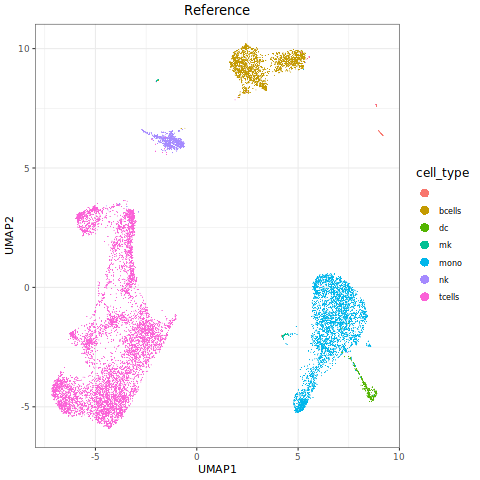

In [14]:
%%R

umap_labels = cbind(ref_metadata, reference$umap$embedding)

fig.size(3, 5)
plotBasic(umap_labels, title = 'Reference', color.by = 'cell_type')

In [15]:
%%R
saveRDS(reference, './testing_reference1.rds')

In [16]:
# %%R
# # Read in Symphony reference to map to
# reference = readRDS('./testing_reference1.rds')

In [17]:
%%R
# Map query
query = mapQuery(query_exp,             # query gene expression (genes x cells)
                 query_metadata,        # query metadata (cells x attributes)
                 reference,             # Symphony reference object
                 do_normalize = FALSE,  # perform log(CP10k+1) normalization on query
                 do_umap = TRUE)        # project query cells into reference UMAP

R[write to console]: Scaling and synchronizing query gene expression

R[write to console]: Found 3451 out of 3451 reference variable genes in query dataset

R[write to console]: Project query cells using reference gene loadings

R[write to console]: Clustering query cells to reference centroids

R[write to console]: Correcting query batch effects

R[write to console]: UMAP

R[write to console]: All done!



In [18]:
%%R -o query,reference
query = knnPredict(query, reference, reference$meta_data$cell_type, k = 5)
query = knnPredict(query, reference, reference$meta_data$cell_subtype, k = 5, save_as = "cell_subtype_pred_knn")

### Visualization of mapping (original Symphony)

In [19]:
%%R
# Sync the column names for both data frames
reference$meta_data$cell_type_pred_knn = NA
reference$meta_data$cell_type_pred_knn_prob = NA
reference$meta_data$cell_subtype_pred_knn = NA
reference$meta_data$cell_subtype_pred_knn_prob = NA
reference$meta_data$ref_query = 'reference'
query$meta_data$ref_query = 'query'

# Add the UMAP coordinates to the metadata
meta_data_combined = rbind(query$meta_data, reference$meta_data)
umap_combined = rbind(query$umap, reference$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

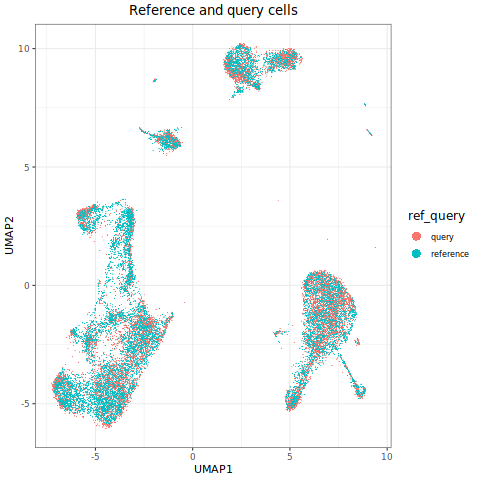

In [20]:
%%R
# Plot UMAP visualization of all cells
fig.size(3, 5)
plotBasic(umap_combined_labels, title = 'Reference and query cells', color.by = 'ref_query')

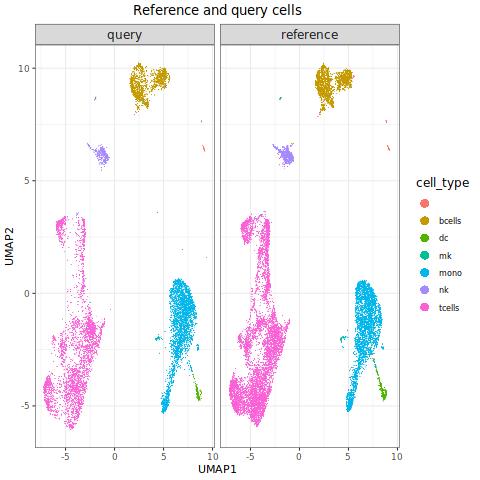

In [21]:
%%R
fig.size(3, 7)
plotBasic(umap_combined_labels, title = 'Reference and query cells', 
          color.by = 'cell_type', facet.by = 'ref_query')

## [Symphonypy implementation](https://github.com/potulabe/symphonypy)

In [22]:
import anndata as ad
import numpy as np
import scanpy as sc
import symphonypy as sp

In [23]:
adata = sc.datasets.pbmc3k()

In [24]:
%%R -i RDS_fp,metadata_fp -o exprs_norm_for_py,metadata_for_py
exprs_norm_for_py = readRDS(RDS_fp)
metadata_for_py = read.csv(metadata_fp, row.names = 1)

In [25]:
%%R -o gene_names,cell_names
gene_names <- rownames(exprs_norm_for_py)
cell_names <- colnames(exprs_norm_for_py)

In [26]:
%%R
rm(exprs_norm_for_py)
rm(metadata_for_py)
rm(gene_names)
rm(cell_names)
gc()

          [,1]   [,2]      [,3]   [,4]      [,5]   [,6]
[1,]   2611448  139.5   4594615  245.4   4594615  245.4
[2,] 148097415 1129.9 300005804 2288.9 257010707 1960.9


In [27]:
adata = ad.AnnData(exprs_norm_for_py.T)
adata.var_names=gene_names
adata.obs_names=cell_names
adata.obs = metadata_for_py
adata.var["highly_variable"] = adata.var_names.isin(var_genes)
adata

/tmp/ipykernel_1899/3066541967.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(exprs_norm_for_py.T)


AnnData object with n_obs × n_vars = 20886 × 33694
    obs: 'cell_id', 'donor', 'nUMI', 'nGene', 'percent_mito', 'cell_type', 'res_0.80', 'cell_subtype'
    var: 'highly_variable'

In [28]:
adata.obs.donor.value_counts()

3'V2    8380
5'      7697
3'V1    4809
Name: donor, dtype: int64

In [29]:
adata_query = adata[adata.obs.donor == "5'"].copy()
adata_query.obs["ref_query"] = "query"

adata_ref = adata[~(adata.obs.donor == "5'")].copy()
adata_ref.obs["ref_query"] = "ref"

In [30]:
raw_counts = False
n_comps = 20
batch_keys = [
    "donor",
]
harmony_args = []
harmony_kwargs = {"sigma": 0.1, "theta": 2, "nclust": 100}
lamb = 1
n_top_genes = 3000
n_neighbours = 5
labels = ["cell_type", "cell_subtype"]
ref_basis_source = "X_pca"
basis_adjusted = "X_pca_adjusted"

ref_basis_loadings = "PCs"
query_basis_ref = "X_pca_ref"

use_genes_column = "highly_variable"
search_highly_variable = (
    use_genes_column == "highly_variable" and "highly_variable" not in adata_ref.var
)

In [31]:
adata_query_ct = adata_query.obs[labels].copy()

In [32]:
adata_ref.obs["batch_symphonypy"] = (
    (adata_ref.obs[batch_keys]).astype(str).agg("_".join, axis=1)
)

if raw_counts:
    if search_highly_variable:
        sc.pp.highly_variable_genes(
            adata_ref,
            batch_key="batch_symphonypy",
            n_top_genes=n_top_genes,
            flavor="seurat_v3",
        )
    sc.pp.normalize_total(adata_ref, target_sum=1e5)
    sc.pp.log1p(adata_ref)

elif search_highly_variable:
    sc.pp.highly_variable_genes(
        adata_ref, batch_key="batch_symphonypy", n_top_genes=n_top_genes
    )

sc.pp.scale(adata_ref, zero_center=True, max_value=10)
adata_ref.X[adata_ref.X < -10] = -10
sc.tl.pca(adata_ref, n_comps=n_comps, zero_center=False)

In [33]:
sp.pp.harmony_integrate(
    adata_ref,
    ref_basis_source=ref_basis_source,
    ref_basis_adjusted=basis_adjusted,
    ref_basis_loadings=ref_basis_loadings,
    key=batch_keys,
    *harmony_args,
    **harmony_kwargs
)

sp.tl.map_embedding(
    adata_ref,
    adata_query,
    key=batch_keys,
    lamb=lamb,
    use_genes_column=use_genes_column,
    adjusted_basis_query=basis_adjusted,
    query_basis_ref=query_basis_ref
)

sp.tl.transfer_labels_kNN(
    adata_ref,
    adata_query,
    labels,
    # kNN args
    n_neighbours,
    ref_basis=basis_adjusted,
    query_basis=basis_adjusted,
    # kNN kwargs
#     weights="distance",
)

2023-01-08 01:03:38,382 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-01-08 01:03:40,546 - harmonypy - INFO - sklearn.KMeans initialization complete.
/home/ku/projs/symphony/symphonypy/tools.py:53: UserWarning: Gene expressions in adata_query should be log1p-transformed
  warnings.warn("Gene expressions in adata_query should be log1p-transformed")


In [34]:
adata_ref

AnnData object with n_obs × n_vars = 13189 × 33694
    obs: 'cell_id', 'donor', 'nUMI', 'nGene', 'percent_mito', 'cell_type', 'res_0.80', 'cell_subtype', 'ref_query', 'batch_symphonypy'
    var: 'highly_variable', 'mean', 'std'
    uns: 'pca', 'harmony'
    obsm: 'X_pca', 'X_pca_adjusted'
    varm: 'PCs'

### Visualization of mapping (symphonypy)

In [35]:
sc.pp.neighbors(
    adata_ref,
    n_pcs=n_comps,
    n_neighbors=20,
    knn=True,
    use_rep=basis_adjusted
)

sc.tl.umap(adata_ref)

sc.tl.ingest(
    adata=adata_query,
    adata_ref=adata_ref,
    embedding_method="umap"
)

In [36]:
adata_joined = adata_ref.concatenate(adata_query)
adata_joined

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 20886 × 33694
    obs: 'cell_id', 'donor', 'nUMI', 'nGene', 'percent_mito', 'cell_type', 'res_0.80', 'cell_subtype', 'ref_query', 'batch_symphonypy', 'batch'
    var: 'highly_variable', 'mean-0', 'std-0'
    obsm: 'X_pca_adjusted', 'X_umap'

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


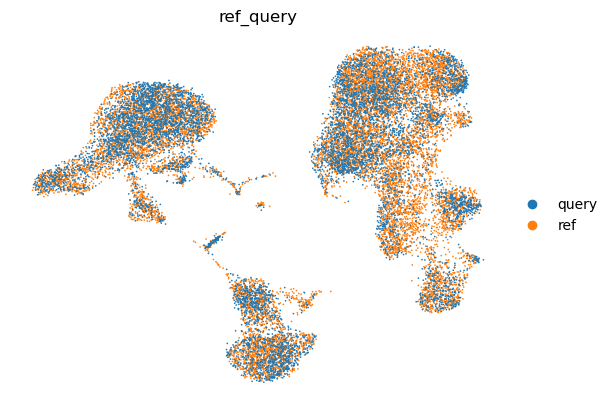

In [37]:
sc.pl.umap(adata_joined, color=['ref_query'], frameon=False)

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


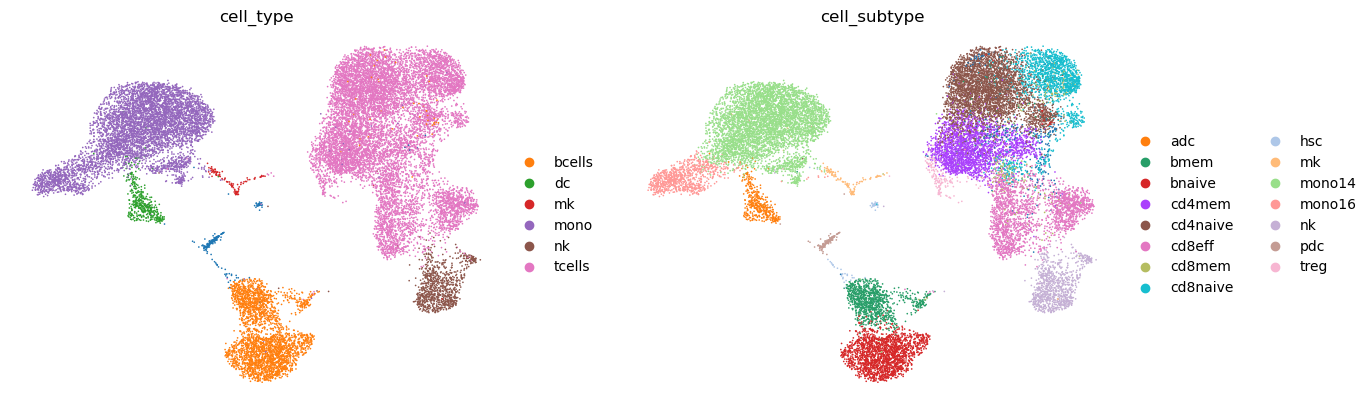

In [38]:
sc.pl.umap(adata_joined, color=['cell_type', 'cell_subtype'], frameon=False)

## Cell type prediction accuracy

### symphony R

In [39]:
cts = query["meta_data"].cell_type.unique()
cts.sort()
csts = query["meta_data"].cell_subtype.unique()
csts.sort()

csts

array(['', 'adc', 'bmem', 'bnaive', 'cd4mem', 'cd4naive', 'cd8eff',
       'cd8mem', 'cd8naive', 'hsc', 'mk', 'mono14', 'mono16', 'nk', 'pdc',
       'treg'], dtype=object)

In [40]:
query["meta_data"]["cell_type_pred_knn"] = cts[query["meta_data"]["cell_type_pred_knn"] - 1]
query["meta_data"]["cell_subtype_pred_knn"] = csts[query["meta_data"]["cell_subtype_pred_knn"] - 1]

In [41]:
labels_symphony_R = ["cell_type_pred_knn", "cell_subtype_pred_knn"]

In [42]:
all(adata_query_ct.index == query["meta_data"].index)

True

In [43]:
(query["meta_data"][labels_symphony_R[0]] == adata_query_ct[labels[0]]).sum(axis=0)

7615

In [44]:
(query["meta_data"][labels_symphony_R[1]] == adata_query_ct[labels[1]]).sum(axis=0)

7014

### symphonypy

In [45]:
(adata_query.obs[labels] == adata_query_ct).sum(axis=0)

cell_type       7618
cell_subtype    7022
dtype: int64

In [46]:
predicted_wrongly = adata_query.obs[labels].loc[(adata_query.obs[labels] != adata_query_ct).values]
right_answer = adata_query_ct.loc[(adata_query.obs[labels] != adata_query_ct).values]

In [47]:
import pandas as pd

In [48]:
predicted_vs_right = pd.DataFrame({"predicted": predicted_wrongly.cell_subtype, "right": right_answer.cell_subtype})

In [49]:
predicted_vs_right.value_counts()

predicted  right 
cd8naive   cd8mem    185
cd4naive   cd4mem     86
                      57
cd4mem     treg       43
                      37
                    ... 
mk         mono14      1
hsc        pdc         1
cd8mem     cd4mem      1
cd8naive   treg        1
cd4mem     nk          1
Length: 62, dtype: int64

In [50]:
adata_query.shape

(7697, 33694)